## Imports

In [ ]:
for i in range(2):
    import glob
    from PIL import Image
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib
    import argparse
    import numpy as np
    from utils.constants import COCO_PANOPTIC_CLASSES, classes_cmap,cmap
    from utils.util import sam_inference, seem_inference, final_mapping, draw_segmentation



## Setting up the SAM mask generator

In [ ]:
sam_checkpoint = "../segment-anything/sam_vit_h_4b8939.pth"

model_type = "vit_h"

device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
#        points_per_side=64,
mask_generator = SamAutomaticMaskGenerator(sam,
        points_per_side=32,
        points_per_batch=64,
        pred_iou_thresh = 0.88,
        stability_score_thresh = 0.95,
        stability_score_offset  = 1.0,
        box_nms_thresh = 0.7,
        crop_n_layers = 0,
        crop_nms_thresh= 0.7,
        crop_overlap_ratio= 512 / 1500,
        crop_n_points_downscale_factor = 1,
        min_mask_region_area = 50,
        output_mode = "binary_mask"
    )


## Deciding if we wanna merge the classes -> 19 classes or keep them as the initial 28.

In [ ]:
map_to_19_classes=False

if map_to_19_classes:
    cmap={0 : [105,105,105],1 : [139, 69, 19],2 : [72,61,139],3 : [0,128,0],4 : [0,139,139],5 : [255,215,0],6 : [255, 255, 0],7 : [176,48,96],8 : [255,0,0],9 : [128,0,0],10: [27,149,224],11: [0,250,154],12: [218,112,214],13: [176,196,222],14: [100, 149, 237],15: [255, 20, 147],16: [123, 104, 238],17: [255, 228, 181],18: [255, 182, 193],255:[0,0,0]}
    classes_cmap={0  :"structure",1  :"sky",2  :"ground",3  :"tree",4  :"ceiling",5  :"furniture",6  :"windowpane",7  :"person",8  :"door",9  :"car",10 :"water",11 :"fence",12 :"stairs",13 :"boat",14 :"plaything",15 :"tent",16 :"minibike",17 :"animals",18 :"others",255:"ignore"}
else:
    classes_cmap={0  :"wall",1  :"building",2  :"sky",3  :"floor",4  :"tree",5  :"ceiling",6  :"road",7  :"furniture",8  :"windowpane",9  :"earth",10 :"sidewalk",11 :"person",12 :"door",13 :"car",14 :"water",15 :"fence",16 :"column",17 :"signboard",18 :"stairs",19 :"boat",20 :"awning",21 :"streetlight",22 :"airplane",23 :"plaything",24 :"tent",25 :"minibike",26 :"animal",27 :"other",255:"ignore"}
    cmap={0 : [105,105,105],1 : [85, 107, 47],2 : [139, 69, 19],3 : [72,61,139],4 : [0,128,0],5 : [0,139,139],6 : [0,0,128],7 : [255,215,0],8 : [255, 255, 0],9 : [143,188,143],10: [128,0,128],11: [176,48,96],12: [255,0,0],13: [20,100,255],14: [27,149,224],15: [0,250,154],16: [220,20,60],17: [0,255,255],18: [218,112,214],19: [176,196,222],20: [255,0,255],21: [250,128,114],22: [255, 255, 84],23: [100, 149, 237],24: [255, 20, 147],25: [123, 104, 238],26: [255, 228, 181],27: [255, 182, 193],255:[0,0,0]}


## Segmentation

It is a colored image


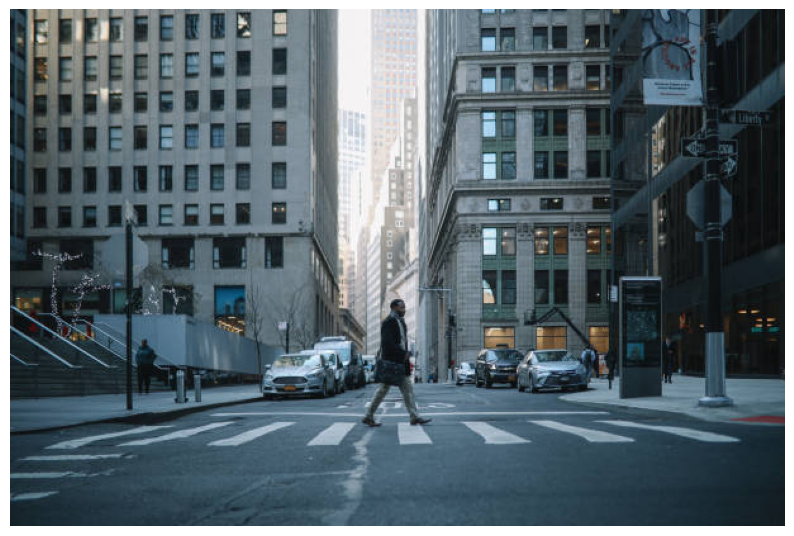

In [ ]:
image_path='../assets/test.png'

image_array=np.array(Image.open(image_path))

#Check if nighttime image
night_image = False
if(image_array[:,:,0]==image_array[:,:,1]).all():
    print('It is a black and white image')
    night_image = True
else:
    print('It is a colored image')

plt.figure(figsize=(10,7))
plt.imshow(image_array)
plt.axis('off')
plt.show()

### Masks generation using SAM

Image shape
(408, 612, 3)
number of masks generated by SAM:194
Percentage of the image that is not segmented 0.08699

------------------------------------------------
Masks generation done, you can now classify them using SEEM
------------------------------------------------



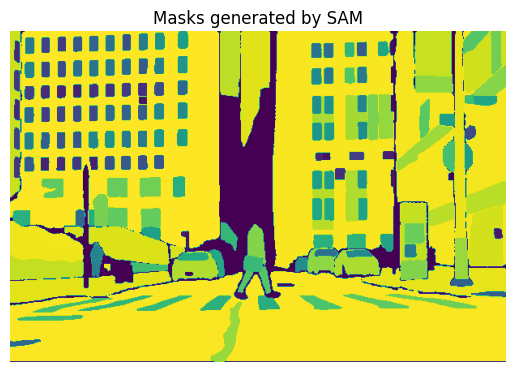

In [ ]:
# The image must have 3 channels even if it's grayscale
if(len(image_array.shape)==2):
    image_array=np.dstack((image_array,image_array,image_array))

print('Image shape')
print(image_array.shape)
mask = sam_inference(image_array,mask_generator)

mask_without_empty_area = mask.copy()
mask_without_empty_area[mask_without_empty_area==30000]=0
plt.imshow(mask_without_empty_area)
plt.axis('off')
plt.title('Masks generated by SAM')
plt.show()


### Masks labeling using SEEM

In [ ]:
result_mask, conf_mask, seem_semantic = seem_inference(image_array, mask)
print(np.array(result_mask).shape)
print(conf_mask.shape)
print(seem_semantic.shape)

(408, 612)
(408, 612, 133)
(408, 612)


### Results

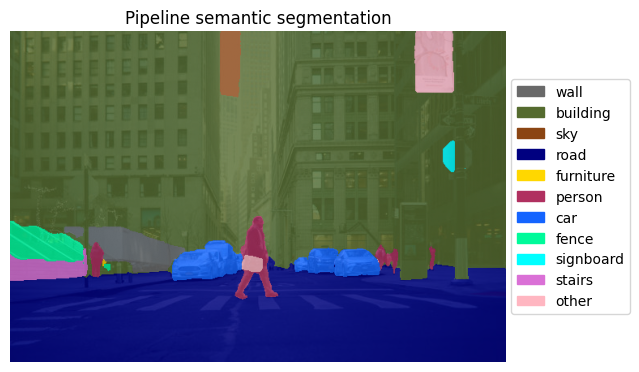

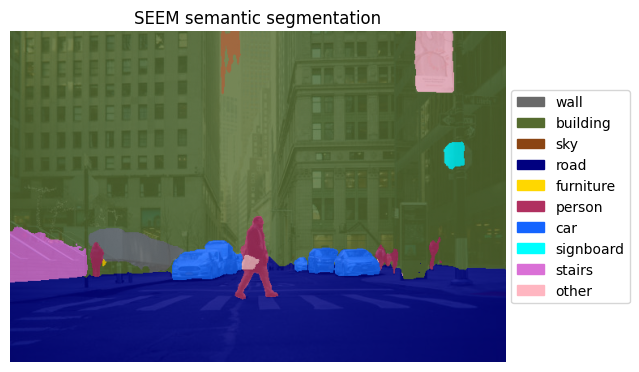

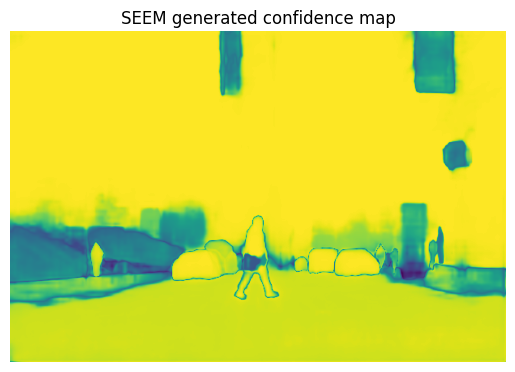

In [ ]:
opacity = 0.8

plt.imshow(image_array)
plt.axis('off')
plt.title('Pipeline semantic segmentation')
if map_to_19_classes:
    draw_segmentation(final_mapping(np.array(result_mask)),a=opacity,cmap=cmap,classes_cmap=classes_cmap)
else:
    draw_segmentation(np.array(result_mask),a=opacity,cmap=cmap,classes_cmap=classes_cmap)

plt.figure()
plt.title('SEEM semantic segmentation')
plt.axis('off')
plt.imshow(image_array)
if map_to_19_classes:
    draw_segmentation(final_mapping(seem_semantic),a=opacity,cmap=cmap,classes_cmap=classes_cmap)
else:
    draw_segmentation(seem_semantic,a=opacity,cmap=cmap,classes_cmap=classes_cmap)


plt.figure()
plt.title('SEEM generated confidence map')
plt.axis('off')
confidence_map_seem=np.amax(conf_mask/np.sum(conf_mask,keepdims=True,axis=-1),axis=-1)
plt.imshow(confidence_map_seem)